# Titanic Survival

Using general linear models to predict survival of passengers in the titanic disaster  
The binomial/binary distribution family is used to fit a logit function.

In [1]:
library(tidyverse) 
PATH="./data"
list.files(path = PATH)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




[1] "gender_submission.csv" "test.csv"              "train.csv"

In [2]:
train_raw = read.table(paste0(PATH,"/train.csv"),sep=",",header=T, stringsAsFactors=F)
test_raw = read.table(paste0(PATH,"/test.csv"),sep=",",header=T, stringsAsFactors=F)
true_pred = read.table(paste0(PATH,"/gender_submission.csv"),sep=",",header=T, stringsAsFactors=F)

## 1. Data pre-processing
Labelling couples as 'married vs unmarried'  
The married women have their name stated as Mrs.<Husband's name> followed by their name within parenthesis, we extract the husbands name and then find the row indices which match with the husband's name, and mark those row's as "married"

In [3]:
train_raw$isTrainSet=1
test_raw$isTrainSet=0
test_raw$Survived=NA

In [4]:
data_combined = rbind(train_raw,test_raw)

In [5]:
data_preprocess = function(dataset){
    ## Derived field "Married" based on Name column
    married_men_names = unique(na.omit(str_match(dataset$Name,"[a-zA-Z]*, Mrs\\. (.*?) \\(.*?\\)$")[,2]))
    x = c()
    for(i in 1:length(married_men_names)){
        x = c(x,(str_which(dataset$Name,married_men_names[i])))
    }
    x = sort(unique(x))
    dataset$isMarried = 0
    dataset$isMarried[x] = 1
    
    ## Clean Cabin column
    dataset$Cabin = str_match(dataset$Cabin,"([a-zA-Z])\\d*?")[,2]
    dataset$Cabin[is.na(dataset$Cabin)] = "U"
    
    dataset = subset(dataset, select = -c(PassengerId,Name,Ticket))
    
    ## Impute missing values in the Age column
    dataset$Age[is.na(dataset$Age)] = median(dataset$Age, na.rm = T)
    dataset[dataset$Embarked=='',"Embarked"] = as.character(getmode(factor(dataset$Embarked)))
    dataset$Fare[is.na(dataset$Fare)] = median(dataset$Fare, na.rm = T)
    
    ## Change type to factor    
    dataset$Pclass = factor(dataset$Pclass)
    dataset$Sex = factor(dataset$Sex)
    dataset$married = factor(dataset$isMarried)
    dataset$Cabin = factor(dataset$Cabin)
    dataset$Embarked = factor(dataset$Embarked)
    
    ## Return cleaned dataset
    dataset
}
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

In [6]:
data_combined_clean = data_preprocess(data_combined)
str(data_combined_clean)

'data.frame':	1309 obs. of  12 variables:
 $ Survived  : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass    : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex       : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age       : num  22 38 26 35 35 28 54 2 27 14 ...
 $ SibSp     : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch     : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare      : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin     : Factor w/ 9 levels "A","B","C","D",..: 9 3 9 3 9 9 5 9 9 9 ...
 $ Embarked  : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ isTrainSet: num  1 1 1 1 1 1 1 1 1 1 ...
 $ isMarried : num  0 1 0 1 1 1 0 1 1 1 ...
 $ married   : Factor w/ 2 levels "0","1": 1 2 1 2 2 2 1 2 2 2 ...


In [7]:
train_clean = subset(data_combined_clean, select=-c(isTrainSet), isTrainSet==1)
train_clean$Survived = factor(train_clean$Survived)
test_clean = subset(data_combined_clean, select=-c(Survived,isTrainSet), isTrainSet==0)

train_proc = subset(train, select = -c(PassengerId,Name,Ticket,Embarked,Cabin))
test_proc = subset(test, select = -c(PassengerId,Name,Ticket,Embarked,Cabin))


In [8]:
head(train_clean,5)
head(test_clean,5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isMarried,married
,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>,<dbl>,<fct>
1,0,3,male,22,1,0,7.2500,U,S,0,0
2,1,1,female,38,1,0,71.2833,C,C,1,1
3,1,3,female,26,0,0,7.9250,U,S,0,0
4,1,1,female,35,1,0,53.1000,C,S,1,1
5,0,3,male,35,0,0,8.0500,U,S,1,1


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isMarried,married
,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>,<dbl>,<fct>
892,3,male,34.5,0,0,7.8292,U,Q,1,1
893,3,female,47.0,1,0,7.0000,U,S,1,1
894,2,male,62.0,0,0,9.6875,U,Q,1,1
895,3,male,27.0,0,0,8.6625,U,S,1,1
896,3,female,22.0,1,1,12.2875,U,S,1,1


## 3. Modelling

In [9]:
formula = as.formula("Survived~Pclass+Sex+Age+SibSp+Parch+Fare+Cabin+Embarked+isMarried")
features = "Pclass+Sex+Age+SibSp+Parch+Fare+Cabin+Embarked+isMarried"

In [10]:
fit = glm(formula, family="binomial", data=train_clean)
summary(fit)


Call:
glm(formula = formula, family = "binomial", data = train_clean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5392  -0.5734  -0.4041   0.6053   2.4834  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   4.324908   0.707733   6.111 9.90e-10 ***
Pclass2      -0.223363   0.436904  -0.511  0.60918    
Pclass3      -1.395055   0.438699  -3.180  0.00147 ** 
Sexmale      -2.742103   0.206401 -13.285  < 2e-16 ***
Age          -0.040196   0.008239  -4.879 1.07e-06 ***
SibSp        -0.322218   0.110670  -2.912  0.00360 ** 
Parch        -0.102795   0.122522  -0.839  0.40148    
Fare          0.002982   0.002714   1.099  0.27190    
CabinB        0.032215   0.712901   0.045  0.96396    
CabinC       -0.491742   0.662141  -0.743  0.45769    
CabinD        0.485489   0.734083   0.661  0.50839    
CabinE        0.991793   0.737192   1.345  0.17851    
CabinF        0.268171   0.982359   0.273  0.78486    
CabinG       -1.560423   1.260

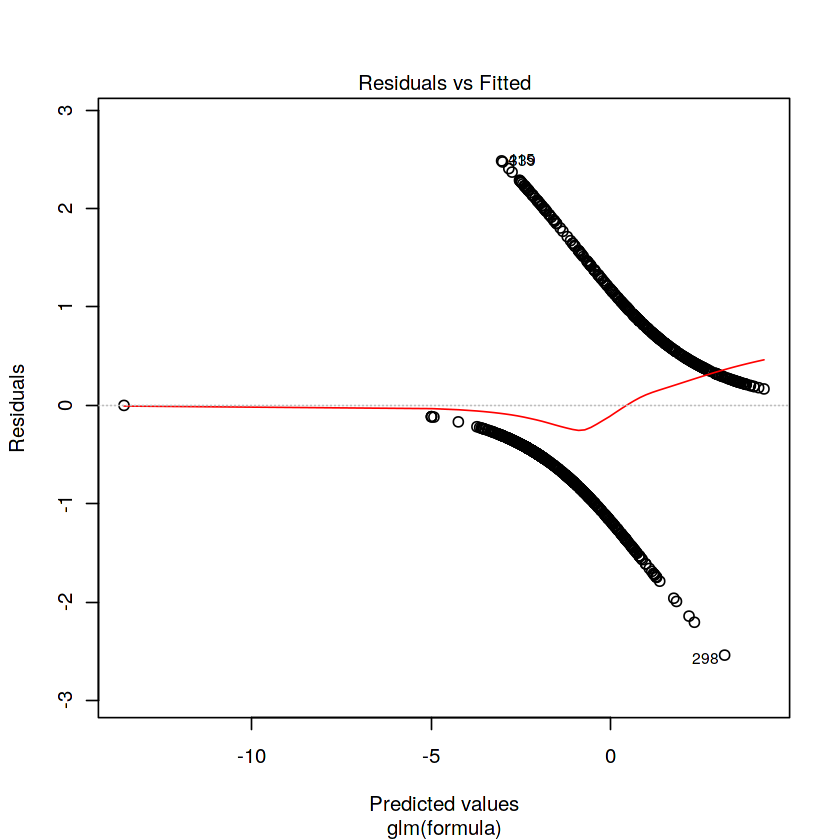

In [11]:
plot(fit, which=1)

In [12]:
pred_train=ifelse(as.numeric(predict(fit))>0.5,1,0)
sum(pred_train==train_clean$Survived,na.rm=T)/819

[1] 0.8949939

In [13]:
pred_test=ifelse(as.numeric(predict(fit,newdata = test_clean))>0.5,1,0)
sum(pred_test==true_pred[,2],na.rm=T)/418

[1] 0.8995215

In [14]:
output_pred = data.frame(PassengerId=test_raw$PassengerId, Survived = pred_test)
write.csv(output_pred, file = "../working/titanic_predictions.csv", row.names=FALSE)